In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA GeForce RTX 4090


# Feature Extraction

**Pre-traineded models**

In [2]:
from timm import create_model
import timm

# timm.list_models("*convnex*", pretrained=True)
netfeat = create_model("convnext_xxlarge.clip_laion2b_soup_ft_in12k", pretrained=True).to(device)
netfeat.head.fc = torch.nn.Identity()
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X   

In [3]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

ds = torchvision.datasets.FashionMNIST('~/lab/ds',train = True, transform=transform, download=True)
dstest = torchvision.datasets.FashionMNIST('~/lab/ds',train = False, transform=transform, download=True)

configfeats(ds)
configfeats(dstest)
len(ds.data)


60000

# Parametric TSNE

In [4]:
from ptsne import train_parametric_tsne_model
from ptsne.config import Config

config = Config()
print(f"Training on {config.dev}", flush=True)

Training on cuda


In [5]:
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

In [6]:
from ptsne.ptsne_net import model

In [7]:
from torch.utils.data import TensorDataset

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

100%|██████████| 120/120 [00:04<00:00, 25.59it/s]

====> Epoch: 1. Time 0:00:04.690711. Average loss: 2.3107



100%|██████████| 120/120 [00:07<00:00, 15.90it/s]

====> Epoch: 2. Time 0:00:07.546479. Average loss: 0.8179



100%|██████████| 120/120 [00:07<00:00, 15.35it/s]

====> Epoch: 3. Time 0:00:07.816065. Average loss: 0.5111



100%|██████████| 120/120 [00:06<00:00, 19.69it/s]

====> Epoch: 4. Time 0:00:06.095333. Average loss: 0.3627



100%|██████████| 120/120 [00:07<00:00, 15.16it/s]

====> Epoch: 5. Time 0:00:07.917437. Average loss: 0.2760



100%|██████████| 120/120 [00:07<00:00, 15.07it/s]

====> Epoch: 6. Time 0:00:07.962490. Average loss: 0.2207



100%|██████████| 120/120 [00:07<00:00, 15.58it/s]

====> Epoch: 7. Time 0:00:07.702117. Average loss: 0.1814



100%|██████████| 120/120 [00:07<00:00, 16.26it/s]

====> Epoch: 8. Time 0:00:07.381738. Average loss: 0.1534



100%|██████████| 120/120 [00:07<00:00, 16.38it/s]

====> Epoch: 9. Time 0:00:07.327469. Average loss: 0.1323



100%|██████████| 120/120 [00:04<00:00, 27.98it/s]

====> Epoch: 10. Time 0:00:04.289393. Average loss: 0.1157
Training time: 0:01:08.731070


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


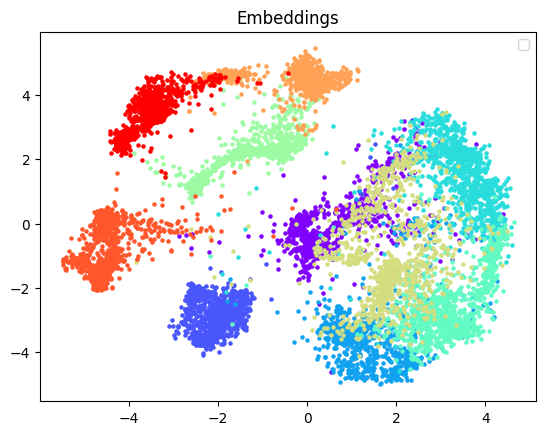

In [8]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

plotsmart(np.array(fs), lbs, "Embeddings", True)

In [9]:
res = {}
ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'] = resmap
resmap

0.7673603738629892

# Parametric UMAP

In [10]:
import sys

try:
    from umap_pytorch import PUMAP
except ImportError:
    print("Pacote 'umap-pytorch' não encontrado. Instalando...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-pytorch"])
    from umap_pytorch import PUMAP 

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

In [11]:
pumap.fit(torch.stack(trainfs))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 14:41:44 2024 Building RP forest with 17 trees
Mon Dec 16 14:41:49 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 695 K  | train
----------------------------------------------------
695 K     Trainable params
0         Non-trainable params
695 K     Total params
2.782     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider incre

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reducing array of shape torch.Size([10000, 3072]) to (10000, 2)


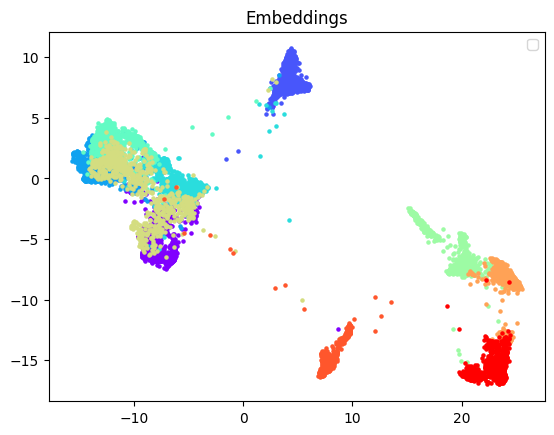

In [12]:
fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))
plotsmart(embedding, lbs, "Embeddings", True)

In [13]:
ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'] = resmap
resmap

0.7558084452810554

In [14]:
res

{'p-tsne': 0.7673603738629892, 'p-umap': 0.7558084452810554}